In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [3]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)
print(g_h.shape)

#print(latitude)

(135,)


In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
#print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
#print(x_g.shape) 

(28, 22)


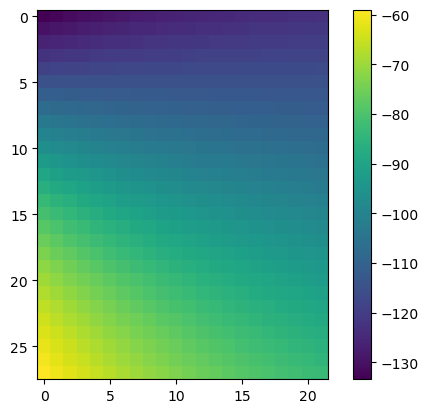

In [5]:
### convert obs lat/long to x,y ###
x_g_m = x_g/100
y_g_m = y_g/100
print(x_g_m.shape)
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = (np.degrees(np.arctan(y_g_m/x_g_m)))+lambda0 #x-cord, y-cord to longitude?
# print(lamda)

# print(psi,lamda)
plt.imshow(lamda)
plt.colorbar()

In [6]:
### Create function for Cressman Analysis ###
sigma = ((1+np.sin(np.radians(60)))/(1+np.sin(np.radians(latitude))))

x_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.cos(np.radians(longitude)+np.radians(115))) #converting coords to x
y_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.sin(np.radians(longitude)+np.radians(115))) #converting coords to y
# print(y_ob.shape)
x_ob = x_ob * map_scale *100 #now in cm
y_ob = y_ob * map_scale *100
x_ob_cm = x_ob
y_ob_cm = y_ob
# x_ob = x_ob/100
# y_ob = y_ob/100
# print('x_ob', x_ob)
# print('y_ob', y_ob)
dmin = 0.0

for i in range(len(x_ob)):
      # distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
      distance_ob_to_ob = np.sqrt(((x_ob[i]-x_ob)**2)+((y_ob[i]-y_ob)**2))
      # print("with zero =",len(distance_ob_to_ob))
      distance_ob_to_ob = np.delete(distance_ob_to_ob,i)
      #distance_ob_to_ob = distance_ob_to_ob[distance_ob_to_ob>1e-10] #------------told in class that dmin = avg minimum distance between obs.
      # print("without zero =",len(distance_ob_to_ob))
      #print('distance_ob_to_ob', distance_ob_to_ob)
      #print('distance_ob_to_ob_shape', distance_ob_to_ob.min())
      dmin = dmin + np.amin(distance_ob_to_ob)   
      # print('dmin is', dmin)
      #dmin = distance_ob_to_ob.min()
      # print(temp)

dmin = dmin/len(x_ob)
print('dmin', dmin)

# dmin_cm = dmin *100 #converting to cm?
dmin_cm = dmin
#print('dmin_cm', dmin_cm)

R1 = 4*dmin_cm
R2 = 2.5*dmin_cm
R3 = 1.5*dmin_cm
#print('R1', R1)

def cressman(R, dik):
        weight = np.zeros(dik.shape)
        for i in range(len(dik)):
            if dik[i] <R:
                numerator = (R**2) - (dik[i]**2)
                denominator = (R**2) + (dik[i]**2)
                weight[i] = numerator / denominator #renamed weight as something such as easier naming for later
                # print('dik**2', dik**2)
                #print('numerator', numerator)
                #print('denominator', denominator)
                # print('weight', weight)
            #else:
            #        numerator = (R**2) - (dik**2)
            #        denominator = (R**2) + (dik**2)
            #        print('R**2', R**2)
            #        print('numerator', numerator)
            #        print('denominator', denominator)
            #        weight=0
        #print('weight', weight)
        return weight

x_g_cm = x_g_m*100
y_g_cm = y_g_m*100
fa = np.zeros((28,22))
w = []
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w = cressman(R1,dik)
              #print('w', w)
              #print('w shape', w.shape)
              fa[i,j] = (np.nansum(w*g_h)/np.nansum(w))
              

#print('D_min =',dmin)
#print('fa', fa)
# plt.contour(fa)


dmin 2.55487008200714


In [7]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin


# print('dmin', dmin)
# print('dik', dik)

# analysis_list = []
# for i in range(len(x_g_cm)):
    # for j in range(len(x_g_cm[i])):
        # num = sum(w[i]*g_h)
        # den = sum(w[i])
        # analysis = num/den
        # analysis_list.append(analysis)
# analysis_list = np.array(analysis_list).reshape(28,22)

print(fa.shape)
        

cressman_1 = cressman(R1, dik)
cressman_2 = cressman(R2, dik)
cressman_3 = cressman(R3, dik)

#print('cressman_1', cressman_1)

(28, 22)


In [ ]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb analysis first pass")
plt.show()

In [889]:
### Create function for bilinear interpolation ###
# g_h_append = []
# g_h_append.append(g_h)
# g_h_append.append((28,22))
# g_h_append = np.array(g_h_append)
# print('g_h_append', g_h_append.shape)

# def bilienar_interp(x_ob_cm, y_ob_cm):
#     # x_k = x_ob*100
#     # y_k = y_ob*100
#     x_k = x_ob_cm
#     y_k = y_ob_cm
#     index_x = ((x_k - x0) / delx)
#     index_y = ((y_k - y0) / dely)

#     #flip x,y to j,i because rows then columns in python
#     BLindex_j = int(np.floor(index_x))
#     BLindex_i = int(np.floor(index_y))

#     # print(BLindex_i,BLindex_i+2)
#     four_xs = x_g_cm[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]
#     four_ys = y_g_cm[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]
#     four_ghs = fa[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]

#     dxk = x_ob_cm - four_xs
#     dyk = y_ob_cm - four_ys

#     print('four_ghs', four_ghs)

#     a_matrix = np.array([
#              [1, np.mean(dxk), np.mean(dyk), np.mean(dxk*dyk)],
#              [np.mean(dxk), np.mean(dyk**2), np.mean(dxk*dyk), np.mean((dxk**2)*dyk)],
#              [np.mean(dyk), np.mean(dxk*dyk), np.mean(dyk**2), np.mean(dxk*(dyk**2))],
#              [np.mean(dxk*dyk), np.mean((dxk**2)*dyk), np.mean(dxk*(dyk**2)), np.mean((dxk**2)*(dyk**2))]
#     ])
    
#     print(a_matrix)

#     b_matrix = np.array([
#                 f0,
#                  np.mean(dxk),
#                  np.mean(dyk),
#                  np.mean(dxk*dyk)])
    

#     coef = np.linalg.inv(a_matrix) @ b_matrix

#     BLvalue = fa[BLindex_j, BLindex_i]
#     # BLvalue = g_h[BLindex_j]
#     return coef

# # for i in range(len(fa)):
# #     for j in range(len(fa)):
# #         f0 = fa[i, j]
# #         test = bilienar_interp(x_ob_cm, y_ob_cm, f0)

# test = bilienar_interp(x_ob_cm, y_ob_cm)
# print(x_ob_cm[2])
# print(y_ob_cm[2])
# print ('test', test)

def bilienar_interp(x_ob_cm, y_ob_cm):
    # x_k = x_ob*100
    # y_k = y_ob*100
    x_k = x_ob_cm
    y_k = y_ob_cm
    index_x = ((x_k - x0) / delx)
    index_y = ((y_k - y0) / dely)
    # print('index_x', index_x)
    # print('index_y', index_y)
    #flip x,y to j,i because rows then columns in python
    # BLindex_j = int(np.floor(index_x))
    # BLindex_i = int(np.floor(index_y))
    x1 = int(np.floor(index_x))
    y1 = int(np.floor(index_y))
    x2 = int(np.ceil(index_x))
    y2 = int(np.ceil(index_y))
    if ((x1>21) or (x1<0) or (x2>21) or (x2<0) or (y1<0) or (y1>27) or (y2<0) or (y2>27)):
        #print('fuck')

        warr = np.zeros((28,22))
        for i in range(len(x_g_cm)):
            for j in range(len(x_g_cm[i])):
                distance_ob_to_analysis = np.sqrt(((x_ob_cm-x_g[i, j])**2)+((y_ob_cm-y_g[i, j])**2))
                dik = distance_ob_to_analysis
                if distance_ob_to_analysis<R1:
                    numerator = (R1**2) - (dik**2)
                    denominator = (R1**2) + (dik**2)
                    warr[i, j] = numerator/denominator
        booger = np.sum(warr*fa)/np.sum(warr)
        if np.sum(warr)>0:
            return booger
        else:
            return np.nan

    x1v = x_calculation[x1]
    y1v = y_calculation[y1]
    x2v = x_calculation[x2]
    y2v = y_calculation[y2]


    a_matrix = np.array([[
        1, x1v, y1v, x1v*y1v],
        [1, x1v, y2v, x1v*y2v],
        [1, x2v, y1v, x2v*y1v],
        [1, x2v, y2v, x2v*y2v]])
    
    # print(a_matrix)


    b_matrix = np.array([
                fa.T[x1, y1],
                fa.T[x1, y2],
                fa.T[x2, y1],
                fa.T[x2, y2]])
    

    coef = np.linalg.inv(a_matrix) @ b_matrix

    pt = np.asarray([1,x_ob_cm, y_ob_cm, x_ob_cm * y_ob_cm])

    result = pt@coef

    return result

# for i in range(len(fa)):
#     for j in range(len(fa)):
#         f0 = fa[i, j]
#         test = bilienar_interp(x_ob_cm, y_ob_cm, f0)

test = bilienar_interp(x_ob_cm[0], y_ob_cm[0])
thing = np.zeros(135)
for i in range(135):
    thing[i] = bilienar_interp(x_ob_cm[i], y_ob_cm[i])
#print('thing', thing.round(2))
# print(x_ob_cm[0])
# print(y_ob_cm[0])
#print ('test', test)

/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_12875/3023767400.py:90: RuntimeWarning: invalid value encountered in scalar divide
  booger = np.sum(warr*fa)/np.sum(warr)


In [890]:
### Next Analyses ###
f_a_2 = np.zeros(135)
for i in range(len(f_a_2)):
    f_a_2[i] = bilienar_interp(x_ob_cm[i], y_ob_cm[i])
#print(np.sum(np.isnan(f_a_2)))
# print(x_ob_cm.shape)
# print(fa.shape)
# print(dik.shape)

fa_new = np.zeros((28,22))
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w2 = cressman(R2,dik)
              fa_new[i, j] = fa[i,j] + np.nansum(w2*(g_h-thing))/np.nansum(w2)
#print('fa_new', fa_new)
#print('fa[0,0]', fa[0, 0])

varr = np.sqrt(np.nansum((g_h-thing)**2)/len(thing[~np.isnan(thing)]))
print(varr)
#print(R2)

74.07880556075993


/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_12875/3023767400.py:90: RuntimeWarning: invalid value encountered in scalar divide
  booger = np.sum(warr*fa)/np.sum(warr)


In [891]:
### Calculate Analysis Differences
f_a_diff = fa_new - fa
#print(f_a_diff)

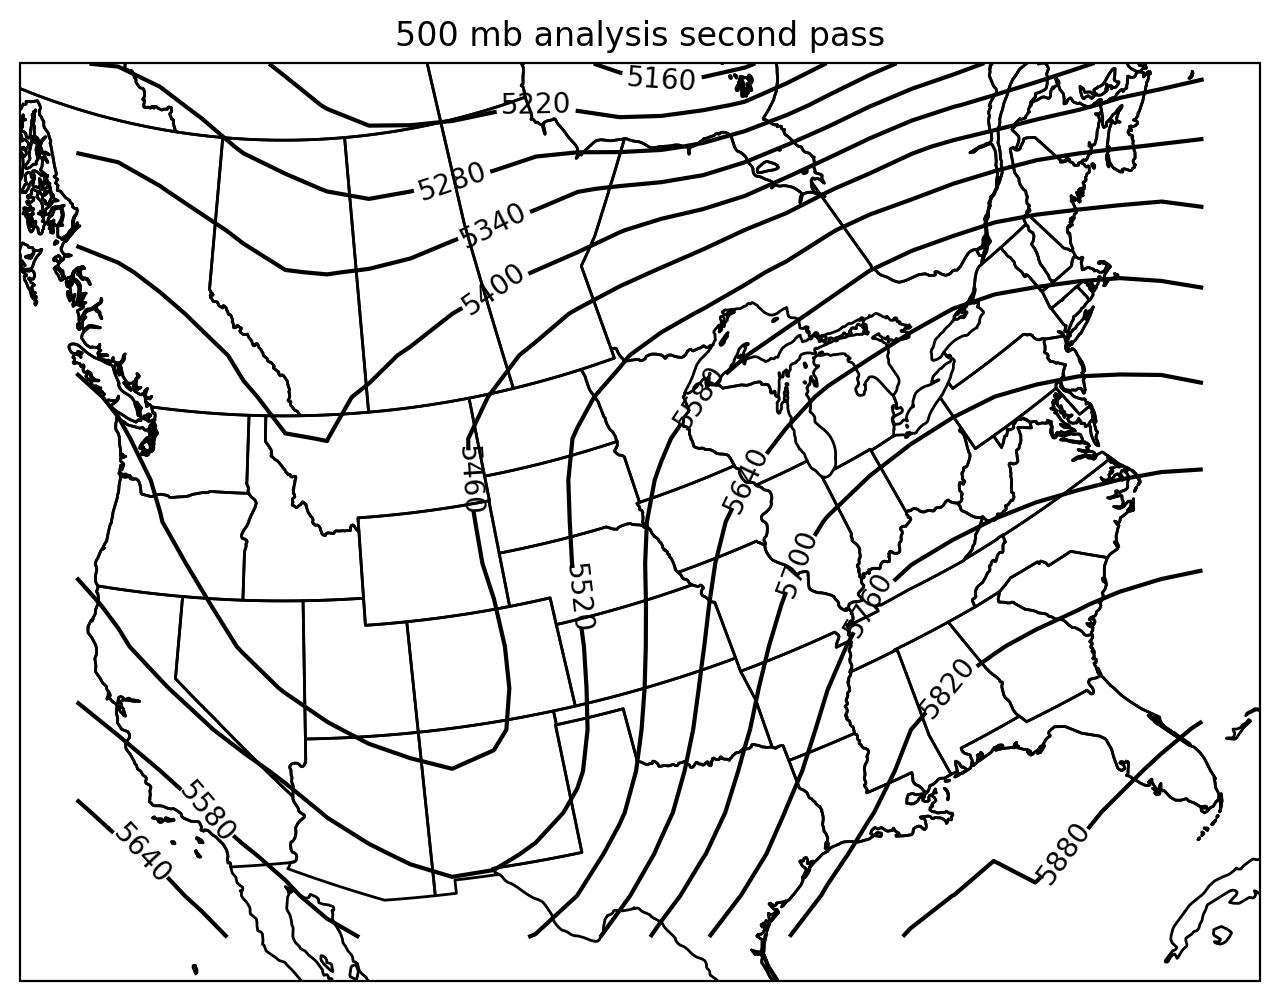

In [892]:
### Plot 500mb analyses over a map ###
#use old code...

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa_new[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb analysis second pass")
plt.show()


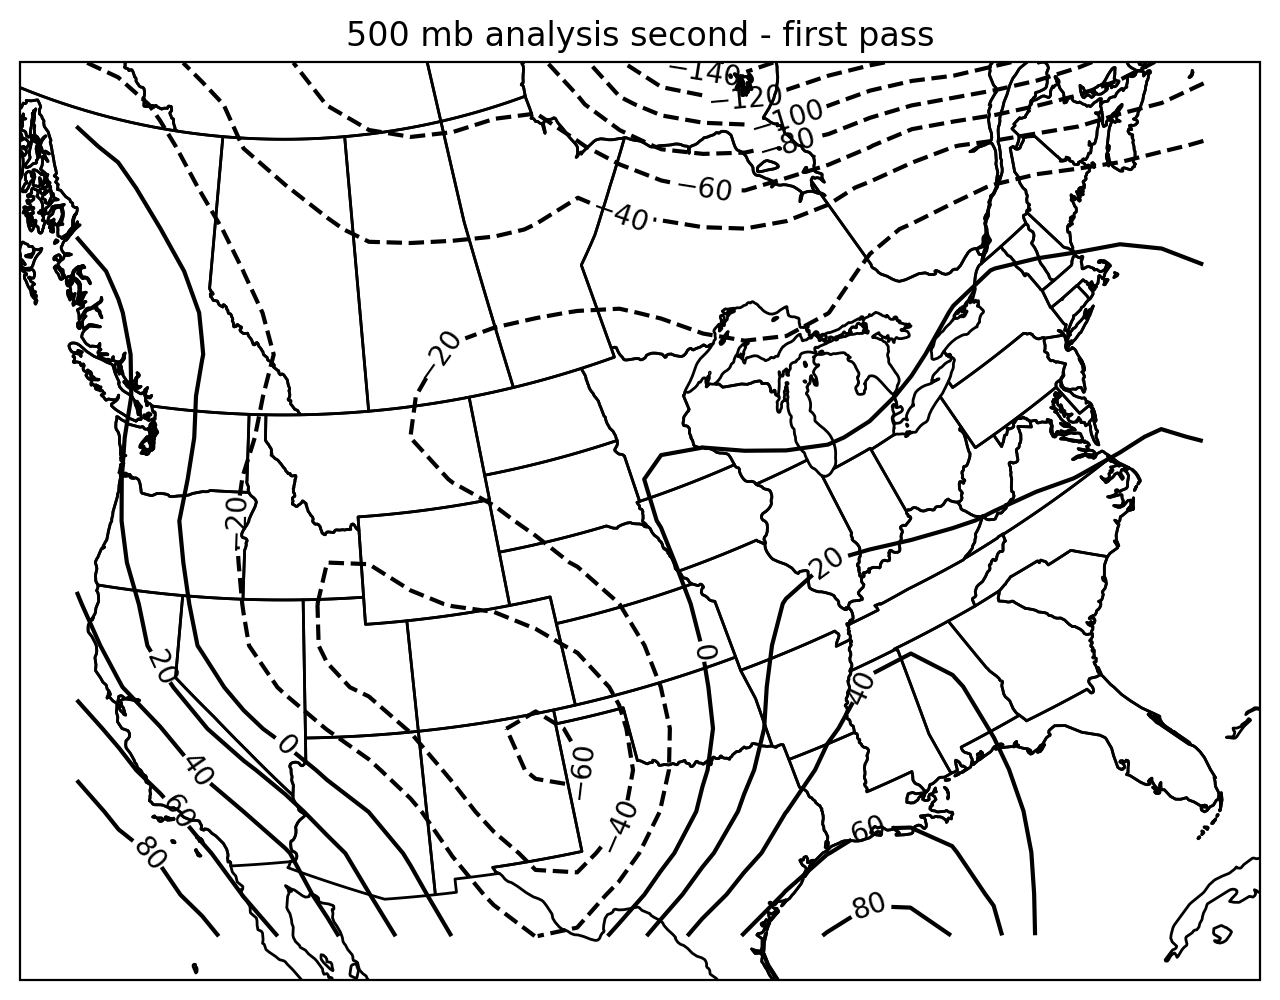

In [893]:
### Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff[:,:],colors='k',levels=np.arange(-800,800,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-800,800,20))
plt.title("500 mb analysis second - first pass")
plt.show()

/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_12875/2572868787.py:29: RuntimeWarning: invalid value encountered in scalar divide
  booger = np.sum(warr*fa)/np.sum(warr)
/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_12875/2572868787.py:97: RuntimeWarning: invalid value encountered in scalar divide
  fa_new2[i, j] = fa[i,j] + np.nansum(w2*(g_h-thing2))/np.nansum(w2)


varr2 74.07880556075993


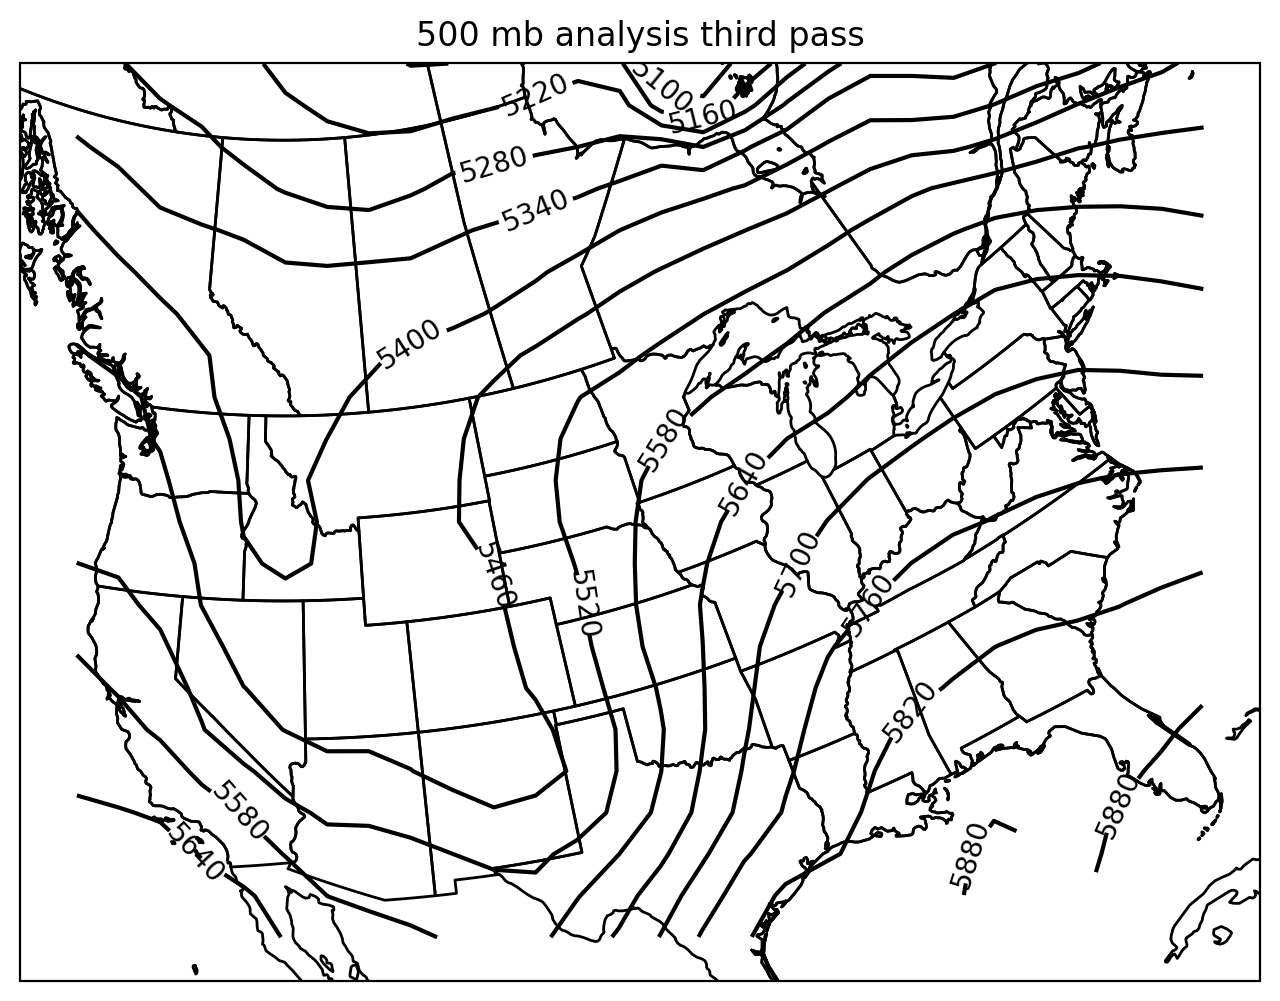

In [894]:
def bilienar_interp(x_ob_cm, y_ob_cm):
    # x_k = x_ob*100
    # y_k = y_ob*100
    x_k = x_ob_cm
    y_k = y_ob_cm
    index_x = ((x_k - x0) / delx)
    index_y = ((y_k - y0) / dely)
    # print('index_x', index_x)
    # print('index_y', index_y)
    #flip x,y to j,i because rows then columns in python
    # BLindex_j = int(np.floor(index_x))
    # BLindex_i = int(np.floor(index_y))
    x1 = int(np.floor(index_x))
    y1 = int(np.floor(index_y))
    x2 = int(np.ceil(index_x))
    y2 = int(np.ceil(index_y))
    if ((x1>21) or (x1<0) or (x2>21) or (x2<0) or (y1<0) or (y1>27) or (y2<0) or (y2>27)):
        #print('fuck')

        warr = np.zeros((28,22))
        for i in range(len(x_g_cm)):
            for j in range(len(x_g_cm[i])):
                distance_ob_to_analysis = np.sqrt(((x_ob_cm-x_g[i, j])**2)+((y_ob_cm-y_g[i, j])**2))
                dik = distance_ob_to_analysis
                if distance_ob_to_analysis<R1:
                    numerator = (R1**2) - (dik**2)
                    denominator = (R1**2) + (dik**2)
                    warr[i, j] = numerator/denominator
        booger = np.sum(warr*fa)/np.sum(warr)
        if np.sum(warr)>0:
            return booger
        else:
            return np.nan

    x1v = x_calculation[x1]
    y1v = y_calculation[y1]
    x2v = x_calculation[x2]
    y2v = y_calculation[y2]


    a_matrix = np.array([[
        1, x1v, y1v, x1v*y1v],
        [1, x1v, y2v, x1v*y2v],
        [1, x2v, y1v, x2v*y1v],
        [1, x2v, y2v, x2v*y2v]])
    
    # print(a_matrix)


    b_matrix = np.array([
                fa.T[x1, y1],
                fa.T[x1, y2],
                fa.T[x2, y1],
                fa.T[x2, y2]])
    

    coef = np.linalg.inv(a_matrix) @ b_matrix

    pt = np.asarray([1,x_ob_cm, y_ob_cm, x_ob_cm * y_ob_cm])

    result = pt@coef

    return result

# for i in range(len(fa)):
#     for j in range(len(fa)):
#         f0 = fa[i, j]
#         test = bilienar_interp(x_ob_cm, y_ob_cm, f0)

test = bilienar_interp(x_ob_cm[0], y_ob_cm[0])
thing2 = np.zeros(135)
for i in range(135):
    thing2[i] = bilienar_interp(x_ob_cm[i], y_ob_cm[i])
#print('thing', thing.round(2))
# print(x_ob_cm[0])
# print(y_ob_cm[0])
#print ('test', test)

### Next Analyses ###
f_a_2 = np.zeros(135)
for i in range(len(f_a_2)):
    f_a_2[i] = bilienar_interp(x_ob_cm[i], y_ob_cm[i])
#print(np.sum(np.isnan(f_a_2)))
# print(x_ob_cm.shape)
# print(fa.shape)
# print(dik.shape)

fa_new2 = np.zeros((28,22))
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w2 = cressman(R3,dik)
              fa_new2[i, j] = fa[i,j] + np.nansum(w2*(g_h-thing2))/np.nansum(w2)
#print('fa_new', fa_new)
#print('fa[0,0]', fa[0, 0])

varr2 = np.sqrt(np.nansum((g_h-thing2)**2)/len(thing2[~np.isnan(thing2)]))
print('varr2', varr2)
#print(R2)

### Plot 500mb analyses over a map ###
#use old code...

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa_new2[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb analysis third pass")
plt.show()

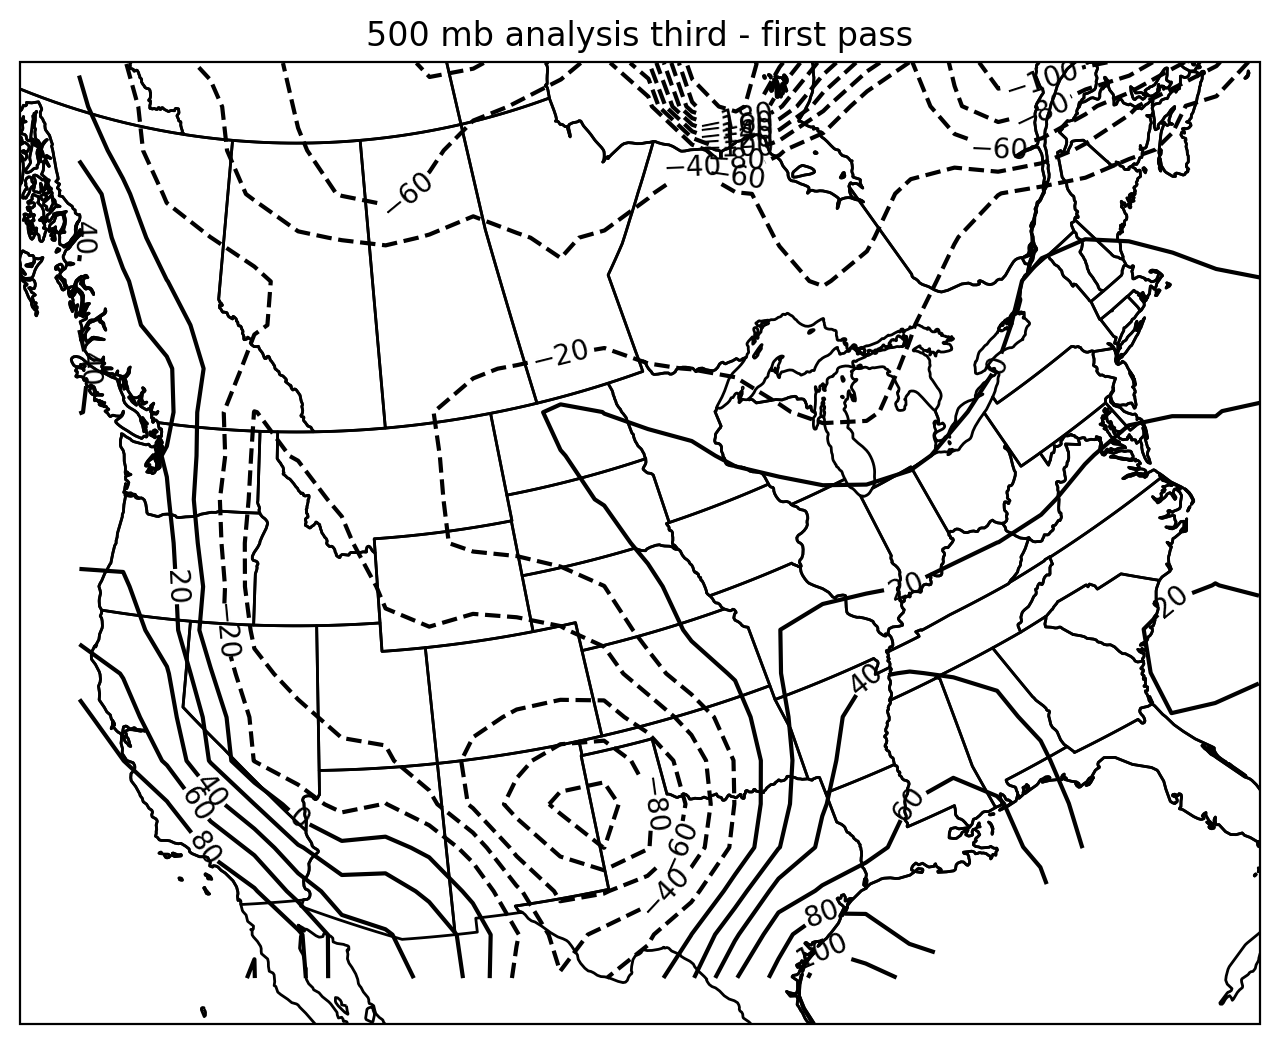

In [895]:
### Calculate Analysis Differences
f_a_diff2 = fa_new2 - fa
#print(f_a_diff)

### Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff2[:,:],colors='k',levels=np.arange(-800,800,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-800,800,20))
plt.title("500 mb analysis third - first pass")
plt.show()

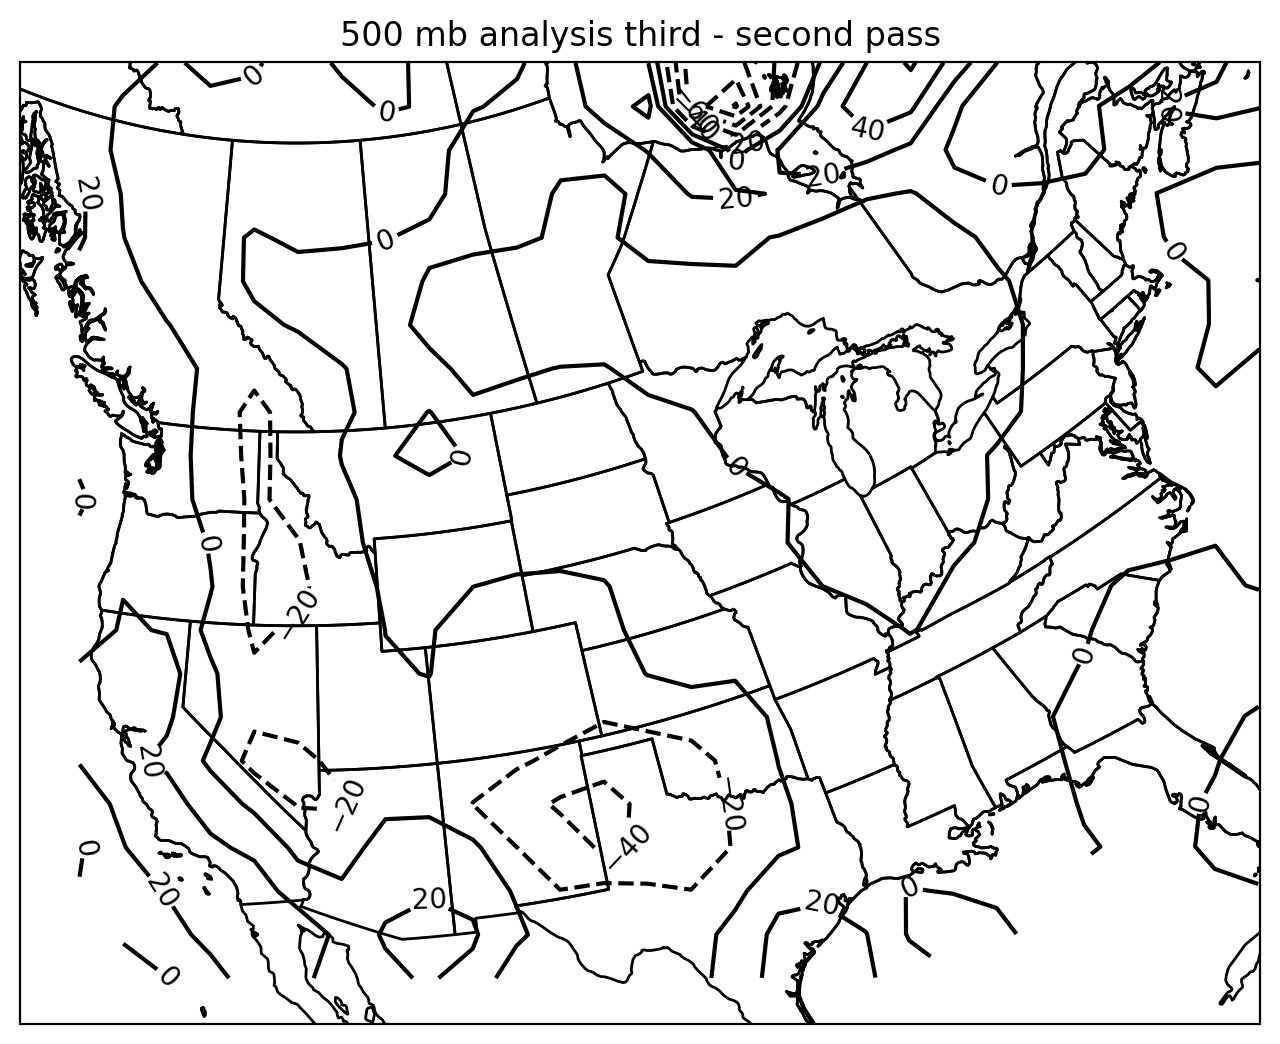

In [896]:
### Calculate Analysis Differences
f_a_diff3 = fa_new2 - fa_new
#print(f_a_diff)

### Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff3[:,:],colors='k',levels=np.arange(-800,800,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-800,800,20))
plt.title("500 mb analysis third - second pass")
plt.show()

In [897]:
### Store the analyses in text files ###
with open('500mb_first_pass.txt','wb') as f:
    for line in fa:
        np.savetxt(f, line, fmt='%.2f')

with open('500mb_second_pass.txt','wb') as f:
    for line in fa_new:
        np.savetxt(f, line, fmt='%.2f')

with open('500mb_third_pass.txt','wb') as f:
    for line in fa_new2:
        np.savetxt(f, line, fmt='%.2f')


In [898]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.



-----------There is a trough over the western United States / Rocky Mountains. It is negatively tilted. There is a ridge over the eastern United States.



2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    


-----------Going from the first to the second then third passes, the trough over the western US becomes more defined. The ridge in the eastern US also becomes more defined.
-----------The first pass is much smoother than the other two, especially the third pass. The third pass is the least smooth. 
Changing the radius of influence means that we are averaging more points in the first pass compared to the third. Including more stations inside larger radii will smooth out values. 



3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?

    

-----------As you increase the number of successive correction passes, you go from analyzing a larger scale phenomena vs a smaller scale phenomena. There is much more fine scale detail to depict. 
This can be desirable, it largely depends on what you are looking to analyze / forecast. 
If you want to know the general trough / ridge pattern over the U.S. you would keep it at the first pass, but if you were forecasting for a particular city, you would want a higher pass analysis.
    

'''
#######   RMSE values ######
print(varr) #Should be 74.08
print(varr2) #Should be 34.01
print(varr3) #Should be 13.23

74.07880556075993
74.07880556075993
52.915437767805166
